<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/main/test_data_preparation_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use the standard CPU.

Note: The code below has been configured to run on Google colab with python scripts imported from google drive. Please download the scripts from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h2>3. Preparation of testing data using simple filters</h2>

Some libraries are used in this notebook

In [1]:
# Sytem handling
import os
import shutil
import sys

# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Image handling
import cv2

# Zip files handling
import zipfile

Similar to there colab instances, mount Google Drive to access the data stored in Google Drive.

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('drive', force_remount=True)

Mounted at drive


<h2>3.1 Data extraction</h2>

As the getFile.py and getData.py were already tested in section 1 when extracting training data, they will be directly imported here.

In [3]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_preparation/getFile.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

Extract the data from the zip file using getFile.py

In [4]:
# Import the extract_zip_to_directory function from getFile.py
from getFile import extract_zip_to_directory

# Define file paths
root_path = 'drive/MyDrive'
zip_filename = os.path.join(root_path, 'GTSRB/GTSRB.zip')
extract_dir = "GTSRB"

# Call the function
extract_zip_to_directory(zip_filename, extract_dir)

Extraction complete.



Test data and their corresponding labels (ground truth) where obtained from the folders using the getData.py


In [5]:
# Assign the paths
ground_truth = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_GT', 'GT-final_test.csv')
test_directory = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_Images', 'GTSRB', 'Final_Test', 'Images')

print("ground_truth:", ground_truth)
print("test_directory:", test_directory)

ground_truth: GTSRB/GTSRB/GTSRB_Final_Test_GT/GT-final_test.csv
test_directory: GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images


In [6]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_preparation/getData.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import getData

In [7]:
images = getData.load_testing_images(test_directory)
labels = getData.load_ground_truth(ground_truth)

Skipping file GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv: cannot identify image file 'GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv'
Loaded 12630 test images in 2.7079625129699707 seconds.


<h2> 3.2 Simple statictics</h2>

The shape of images are checked and the labels(class ID) are displayed

In [8]:
images.shape

(12630, 32, 32, 3)

In [9]:
labels["ClassId"]

0        16
1         1
2        38
3        33
4        11
         ..
12625    12
12626    33
12627     6
12628     7
12629    10
Name: ClassId, Length: 12630, dtype: int64

The staticstics of the labels are calculated. This function is modified from the calculate_label_statistics function in the simple statistics for training data (Chapter 2.2). The function is changed so that it can be used for testing data in the form of dataframe.

In [10]:
def calculate_column_statistics(df, column_name):
    """
    Calculate statistics for a DataFrame's column.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: Name of the column to calculate statistics for.

    Returns:
    A dictionary containing the calculated statistics.
    """
    # Extract the specified column
    column_data = df[column_name]

    # Calculate the label distribution
    unique_values, value_counts = np.unique(column_data, return_counts=True)
    value_distribution = dict(zip(unique_values, value_counts))

    # Extract values and counts from the value distribution dictionary
    values_list = list(value_distribution.keys())
    counts = list(value_distribution.values())

    # Sort values and counts by value names
    sorted_indices = np.argsort(values_list)
    values_list = np.array(values_list)[sorted_indices]
    counts = np.array(counts)[sorted_indices]

    # Calculate statistics
    total_values = sum(counts)
    average_values = total_values / len(unique_values)
    median_values = np.median(counts)
    std_deviation = np.std(counts)
    min_index = np.argmin(counts)
    max_index = np.argmax(counts)

    # Get values for minimum and maximum counts
    min_value = values_list[min_index]
    max_value = values_list[max_index]
    min_count = counts[min_index]
    max_count = counts[max_index]

    # Return statistics as a dictionary
    statistics = {
        "average count": average_values,
        "median count": median_values,
        "standard deviation": std_deviation,
        "min value": min_value,
        "max value": max_value,
        "min count": min_count,
        "max count": max_count,
    }

    return statistics

Similarly, the ploting of label distribution is also modified to be used for testing data in the form of dataframe.

In [11]:
def plot_label_distribution(df, column_name):
    """
    Create a bar plot for label distribution in a DataFrame's column.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: Name of the column to plot the distribution for.

    Returns:
    None
    """
    # Extract the specified column
    labels = df[column_name]

    # Calculate the label distribution
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique_labels, label_counts))

    # Extract labels and counts from the label distribution dictionary
    labels_list = list(label_distribution.keys())
    counts = list(label_distribution.values())

    # Sort labels and counts by label names
    sorted_indices = np.argsort(labels_list)
    labels_list = np.array(labels_list)[sorted_indices]
    counts = np.array(counts)[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(labels_list, counts, tick_label=labels_list, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.xticks(labels_list, rotation=45)
    plt.tight_layout()

    plt.show()

The distribution of the test data is plotted and the statistics are calculated below:

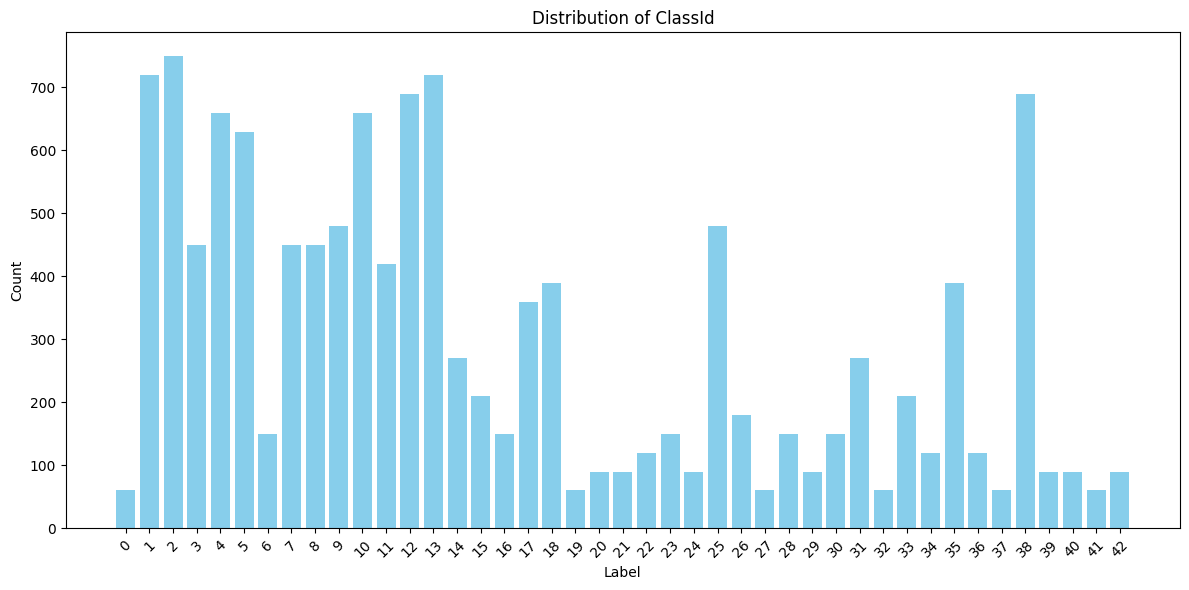

In [12]:
plot_label_distribution(labels, 'ClassId')

In [13]:
statistics = calculate_column_statistics(labels, 'ClassId')
print(statistics)

{'average count': 293.72093023255815, 'median count': 180.0, 'standard deviation': 230.71197442551764, 'min value': 0, 'max value': 2, 'min count': 60, 'max count': 750}


It was noted that the data is also extremely imbalanced. The largest class has 750 images while the smallest class has only 60 image.

Augmentation technices will be needed to make the data more balanced and close to the average count of about 293 images.

From the graph above, it was noted that the distribution of the test data is imbalanced. However, the data distribution (shape) is **similar to the original training data.**

Thus, the decision is to use this data for the testing **without any data augmentation**. However, **data enhancement technices will still be used**.

<h2> 3.3 Data Processing </h2>

Similar to that of the training data, the data processing is done using the processing_image.py. Bicubic interpolation upscaling, histogram equalization and denoising will be used.

In [14]:
# Define the path to the processing_image.py script
script_path = 'drive/MyDrive/final/data_augmentation/processing_image.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

# Import the processing_image function (see processing_image.py for details)
import processing_image

In [15]:
# surpress heartbeat std output by the denoising function
%%capture
# Convert data to unit8
class_images = processing_image.convert_image_format(images)

# Call the fast non local denoising function with the converted images
upscale_factor = 5
upscaled_images = processing_image.upscale_images(class_images, upscale_factor)

# Call the fast non local denoising function with the converted images
denoised_images = processing_image.denoise_images_bilateral(upscaled_images)

# Call the equalize_images function
equalized_images = processing_image.equalize_images_with_AHE(denoised_images)

# Call the guassian_smoothing function
smoothed_images = processing_image.gaussian_smoothing(equalized_images)

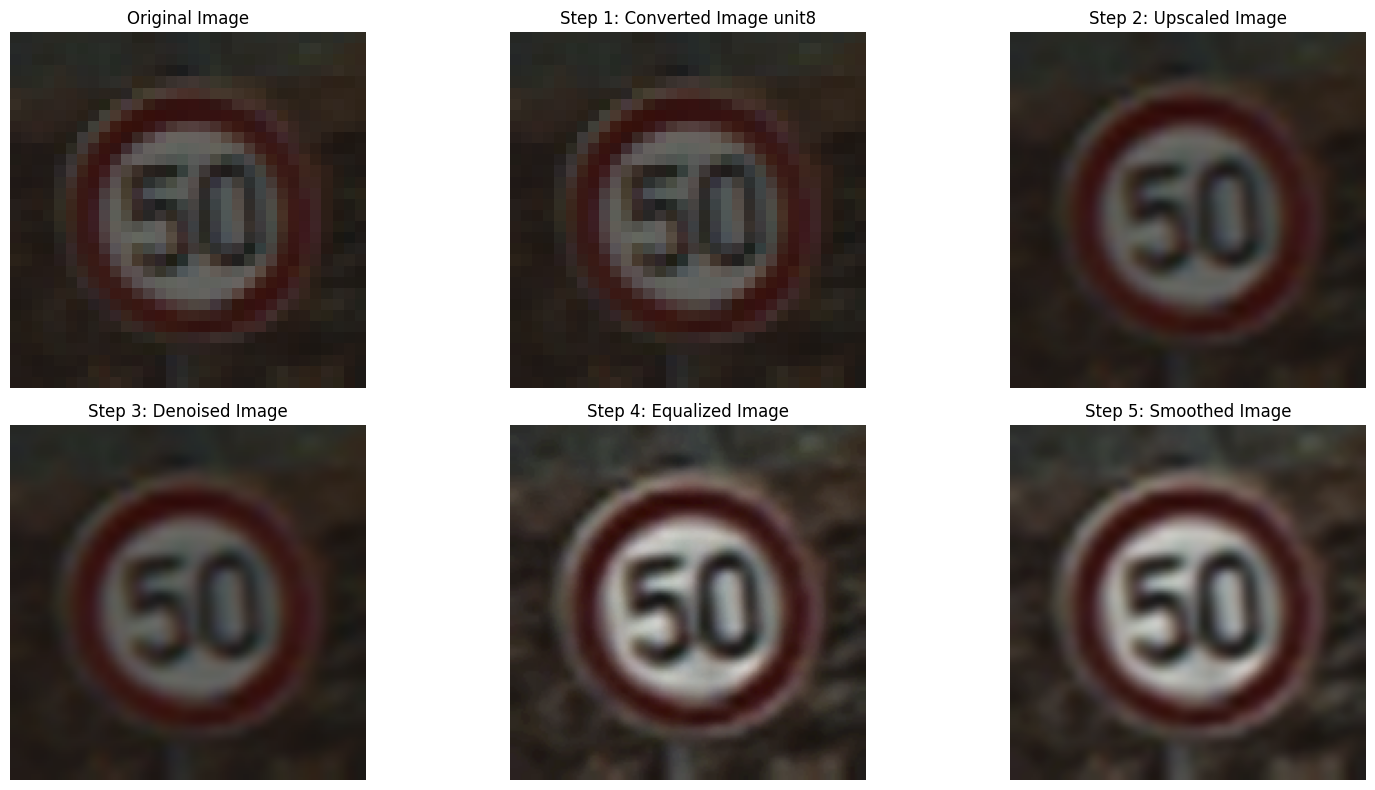

In [18]:
idx = np.random.randint(0, len(images))

# Display the original image, upscaled image, equalized image, denoised image, and smoothed image
plt.figure(figsize=(16, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(images[idx])
plt.title("Original Image")
plt.axis("off")

# unit8 Image
plt.subplot(2, 3, 2)
plt.imshow(class_images[idx])
plt.title("Step 1: Converted Image unit8")
plt.axis("off")

# Upscaled Image
plt.subplot(2, 3, 3)
plt.imshow(upscaled_images[idx])
plt.title("Step 2: Upscaled Image")
plt.axis("off")

# Denoised Image
plt.subplot(2, 3, 4)
plt.imshow(denoised_images[idx])
plt.title("Step 3: Denoised Image")
plt.axis("off")

# Equalized Image
plt.subplot(2, 3, 5)
plt.imshow(equalized_images[idx])
plt.title("Step 4: Equalized Image")
plt.axis("off")

# Smoothed Image
plt.subplot(2, 3, 6)
plt.imshow(smoothed_images[idx])
plt.title("Step 5: Smoothed Image")
plt.axis("off")


plt.tight_layout()
plt.show()

From the images above, the images after processing are clearer and of higher resolution. It also pears to have lesser noise as compared to the original images.

Althought there are matrix such as median absolute deviation (MAD) to evaluate the noise of images, it is difficult to quantatatively evaluate the overall quality of the enhanced images as this is very perceptive.  Thus, the images are not enhanced further.

<h2> 3.4 Data Augmentation </h2>

The shape of the image array is checked and confirmed that the total number of images remains unchanged but the size of each image increased to 160 by 160 pixels.

In [17]:
smoothed_images.shape

(12630, 160, 160, 3)

As calculated in section 3.2, the desirednumber of images per class is 293 (averaged over all classes). Thus image augmentation is needed to increase the number of images per class to 293 for all classes that has less than 293 images.

In [ ]:
# Calculate the desired number of images per class
desired_images_per_class = 293

# Loop through each class
unique_labels = np.unique(labels["ClassId"])
augmented_images = []
augmented_labels = []

A **nested for loop** is used to perform the augmentation throughout all classes and all images. The augmentated images and labels are appended to the original lists and forms final images and labels.

In [ ]:
for label in unique_labels:
    # Select images belonging to the current class
    class_indices = np.where(labels["ClassId"] == label)[0]
    class_images = smoothed_images[class_indices]

    # Calculate how many images need to be augmented
    images_needed = max(0, desired_images_per_class - class_images.shape[0])

    # Augment existing images to meet the desired count
    for _ in range(images_needed):
        # Randomly select an index from the existing images
        random_index = np.random.randint(0, class_images.shape[0])

        # Select the image to be augmented
        image_to_augment = class_images[random_index]

        # Apply augmentation techniques using OpenCV
        augmented_image = processing_image.apply_augmentations(image_to_augment)

        # Append augmented image and label to the lists
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented images and original images
final_images = np.concatenate((smoothed_images, augmented_images), axis=0)
final_labels = np.concatenate((labels["ClassId"], augmented_labels), axis=0)

The shape of the final images is checked below and confirmed that the number of images per class increased as expected.

In [ ]:
final_images.shape

(17008, 160, 160, 3)

A distribution of the final images is plotted below.

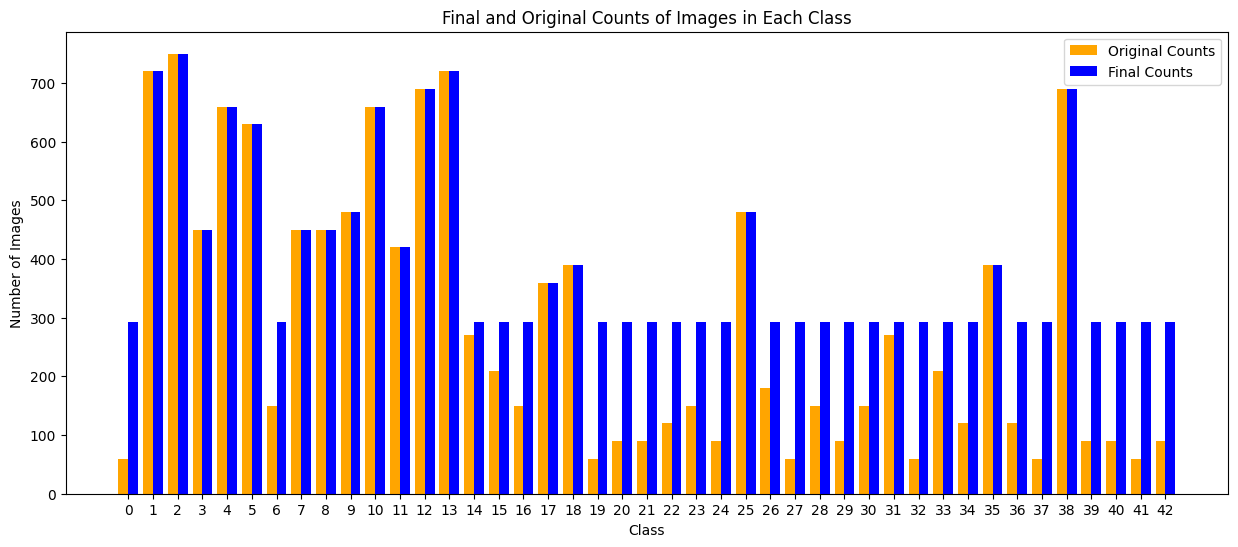

In [ ]:
# Calculate the counts of images in each class for both final and original data
final_class_counts = np.bincount(final_labels)
original_class_counts = np.bincount(labels["ClassId"])

# Number of classes
num_classes = len(final_class_counts)

# Create an array of class labels
class_labels = np.arange(num_classes)

# Calculate the bar width and the gap between original and final counts
bar_width = 0.4
gap = 0.2

# Calculate the positions for the bars
original_bar_positions = class_labels * (2 * bar_width + gap) - bar_width / 2
final_bar_positions = class_labels * (2 * bar_width + gap) + bar_width / 2

# Plot the graph
plt.figure(figsize=(15, 6))

# Plot original counts in orange
plt.bar(original_bar_positions, original_class_counts, color='orange', width=bar_width, label='Original Counts')

# Plot final counts in blue
plt.bar(final_bar_positions, final_class_counts, color='blue', width=bar_width, label='Final Counts')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Final and Original Counts of Images in Each Class')
plt.xticks(class_labels * (2 * bar_width + gap), class_labels)  # Adjust xticks positions
plt.legend()
plt.show()


With reference to the graph above, it was noted that the minimum number of images per class is 293, which is the desired number of images per class.

One image per class is selected and displayed below to check the quality of the augmented images.

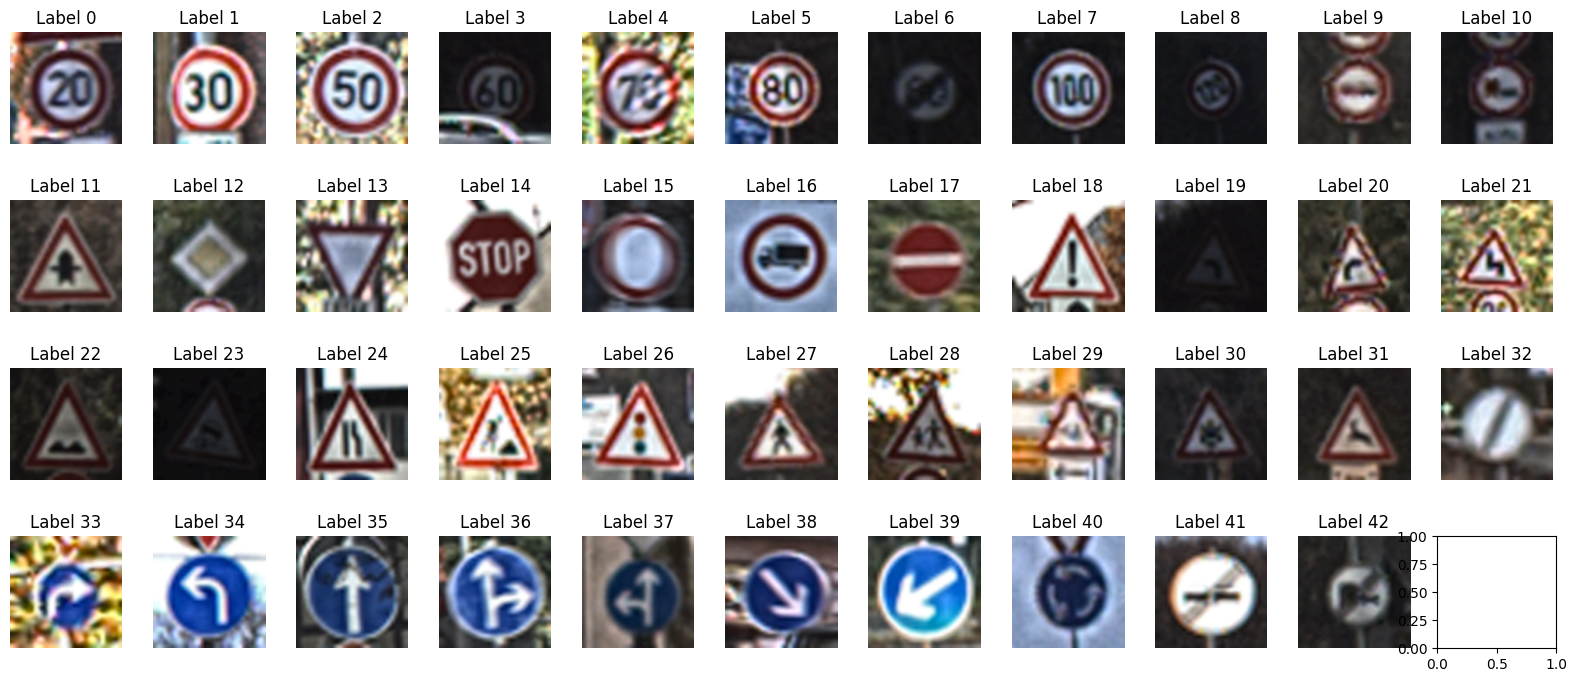

In [ ]:
# Get unique labels
unique_labels = np.unique(final_labels)

# Create a 4x11 grid of subplots
fig, axes = plt.subplots(4, 11, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)

# Initialize counters for rows and columns
row, col = 0, 0

# Iterate through unique labels and select one image per label
for label in unique_labels:
    # Find the first index where the label appears in 'final_labels'
    index = np.where(final_labels == label)[0][0]

    # Get the corresponding image
    image = final_images[index]

    # Display the image in the current subplot
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label {label}')
    axes[row, col].axis('off')

    # Move to the next column
    col += 1

    # Move to the next row and reset the column counter
    if col == 11:
        col = 0
        row += 1

    # displayed all images, break
    if row == 4:
        break

# Remove any empty subplot there are 43unique labels
for i in range(row + 1, 4):
    for j in range(11):
        fig.delaxes(axes[i, j])

plt.show()


It was noted that the quality of the augmented images are much **better** than the original images. However, the quality of this enhancement technique is not as good as the ESRGAN technique.

To achieve a better quality of machine learning model, some data is filtered to make sure the testing data of the model is **perfectly balanced**.

A for loop is used to perform the filtering by checking the number of images per class. It will randomly **remove** images from each class until the **desired number of images** per class is achieved.

In [ ]:
# Create a list of unique class labels
unique_labels = np.unique(final_labels)

# Initialize lists to store the filtered images and labels
filtered_images = []
filtered_labels = []

# Loop through each unique class label
for label in unique_labels:
    # Get the indices of images with the current class label
    class_indices = np.where(final_labels == label)[0]

    # Shuffle the indices randomly
    np.random.shuffle(class_indices)

    # Keep the first indices then add them to the filtered data until the desired number
    filtered_images.extend(final_images[class_indices[:desired_images_per_class]])
    filtered_labels.extend(final_labels[class_indices[:desired_images_per_class]])

# Convert the filtered data back to NumPy arrays
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

# Check the shape of the filtered data
print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (12599, 160, 160, 3)
Filtered Labels Shape: (12599,)


The shape of the filtered images is checked and confirmed that the number of images per class **decreased** as expected. A distribution of the filtered images is plotted below to check for the **number of images in each class**.

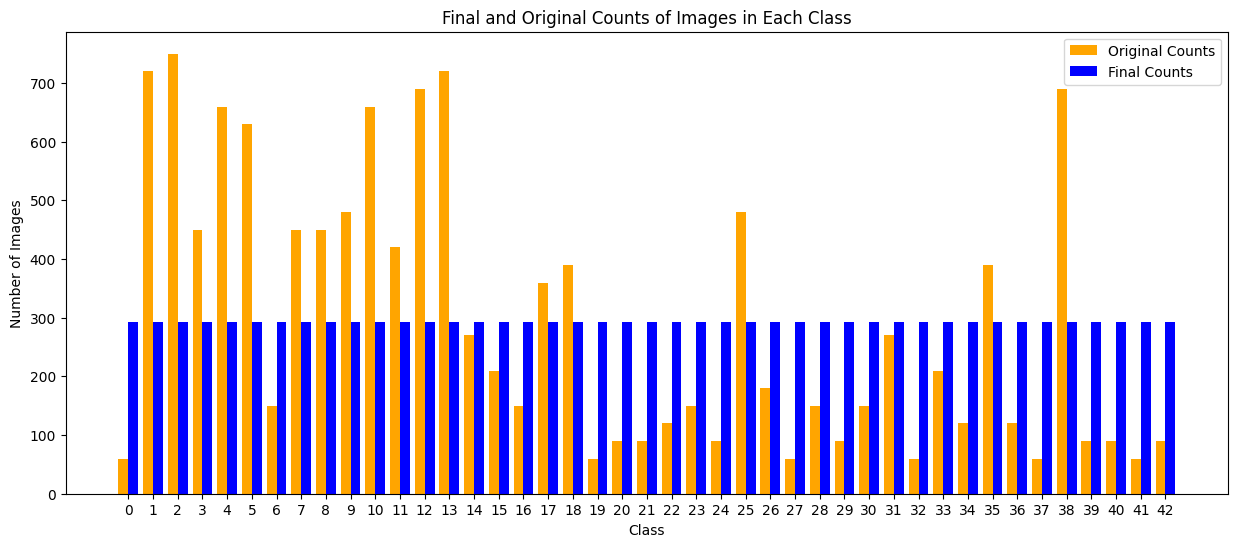

In [ ]:
# Calculate the counts of images in each class for both final and original data
final_class_counts = np.bincount(filtered_labels)
original_class_counts = np.bincount(labels["ClassId"])

# Number of classes
num_classes = len(final_class_counts)

# Create an array of class labels
class_labels = np.arange(num_classes)

# Calculate the bar width and the gap between original and final counts
bar_width = 0.4
gap = 0.2

# Calculate the positions for the bars
original_bar_positions = class_labels * (2 * bar_width + gap) - bar_width / 2
final_bar_positions = class_labels * (2 * bar_width + gap) + bar_width / 2

# Plot the graph
plt.figure(figsize=(15, 6))

# Plot original counts in orange
plt.bar(original_bar_positions, original_class_counts, color='orange', width=bar_width, label='Original Counts')

# Plot final counts in blue
plt.bar(final_bar_positions, final_class_counts, color='blue', width=bar_width, label='Final Counts')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Final and Original Counts of Images in Each Class')
plt.xticks(class_labels * (2 * bar_width + gap), class_labels)  # Adjust xticks positions
plt.legend()
plt.show()

It can be confirmed that the number of images per class is the same and now the data is **perfectly balanced**.

<h2>3.5 Data saving</h2>

To allow the utilization of the data for evaluating the performance of the model, the data is saved in google drive. This allows retrieval of the data in a different environment.

The augmented images are first saved and zipped in the** current colab environment**.

In [ ]:
# Define the directory where augmented images will be saved
augmented_images_directory = 'augmented_images'

# Create the directory if it doesn't exist
if not os.path.exists(augmented_images_directory):
    os.makedirs(augmented_images_directory)

# Iterate through the images in final_images and their corresponding labels
for i, (image, label) in enumerate(zip(filtered_images, filtered_labels)):
    # Generate the filename in the format "class_number.png"
    filename = f'{label}_{i + 1}.png'

    # Create the full path to save the image
    image_path = os.path.join(augmented_images_directory, filename)

    # Save the image
    plt.imsave(image_path, image)

print(f"Augmented images saved in '{augmented_images_directory}' directory.")

Augmented images saved in 'augmented_images' directory.


The number of files in the folder is checked below. It can be confirmed that the number of files is the same as the total number of images.

In [ ]:
# Specify the directory path
folder_path = 'augmented_images'

# List all files in the directory
file_list = os.listdir(folder_path)

# Count the number of files
num_files = len(file_list)

print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 12599


In [ ]:
shutil.make_archive('enhanced_images', 'zip', folder_path)

# Move the zip file to Google Drive
zip_path = 'enhanced_images.zip'
drive_save_path = '/content/drive/MyDrive/final/test_data/test_image_enhanced_PIL_simple.zip'
shutil.move(zip_path, drive_save_path)

'/content/drive/MyDrive/final/test_data/test_image_enhanced_PIL_simple.zip'

Finally, the zipped file is moved to Google Drive using an **absolute path**.

A dataframe is created to store the augmented images and their corresponding labels and then **saved to a CSV file**.

In [ ]:
# Create an empty DataFrame to store the data
data = {'filename': [], 'class': []}

# Iterate through the images in final_labels and their corresponding labels
for i, (image, label) in enumerate(zip(filtered_images, filtered_labels)):
    # Generate the filename in the format "class_number.png"
    filename = f'{label}_{i + 1}.png'

    # Add the filename and class to the data dictionary
    data['filename'].append(filename)
    data['class'].append(label)

# Create a DataFrame from the data dictionary
df = pd.DataFrame(data)

# Define the CSV file path
csv_file_path = 'augmented_images.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print(f"CSV file '{csv_file_path}' created.")

CSV file 'augmented_images.csv' created.


The head of the dataframe is displayed below.

In [ ]:
df.head()

,filename,class
0,0_1.png,0
1,0_2.png,0
2,0_3.png,0
3,0_4.png,0
4,0_5.png,0


Similar to the previous step, the CSV file is moved to Google Drive using an **absolute path**.

In [ ]:
# Define the source CSV file path
source_csv_path = csv_file_path

# Define the destination folder in your Google Drive
destination_folder = "/content/drive/MyDrive/final/test_data"

# Define the new filename for the CSV file
new_csv_filename = "test_image_enhanced_simple_data.csv"

# Move the CSV file to your Google Drive and rename it
shutil.move(source_csv_path, os.path.join(destination_folder, new_csv_filename))

'/content/drive/MyDrive/final/test_data/test_image_enhanced_simple_data.csv'